In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import matplotlib as mpl
import sklearn

In [4]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('noAnno_train_8_nucleotide_array_no_cluster0.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('noAnno_train_8_nucleotide_labels_no_cluster0.npy')
y_train = y_flt_train.astype(int)-1  # Renumber the classes to #cluster-1
y_train_oh = to_categorical(y_train, num_classes=44)  # Make labels into one-hot encode. 
y_train_cluster_number = set(y_train)

dict_test = np.load('noAnno_test_8_nucleotide_array_no_cluster0.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('noAnno_test_8_nucleotide_labels_no_cluster0.npy')
y_test = y_flt_test.astype(int)-1  # Renumber the classes to #cluster-1
y_test_oh = to_categorical(y_test, num_classes=44)  # Make labels into one-hot encode.
y_test_cluster_number = set(y_test)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

Training features shape: (7997, 8, 4)
Test features shape: (3977, 8, 4)
Training labels shape: (7997, 44)
Test labels shape: (3977, 44)


In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2024-01-09 14:41:50.385373: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-09 14:41:50.385393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-09 14:41:50.385396: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-09 14:41:50.385932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 14:41:50.386059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def make_model1(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(16, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [7]:
def make_model2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [8]:
def make_model3(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(128, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [9]:
# Plot loss and accuracy.
def plot_metrics(history1, history2, history3):
  metrics = ['loss', 'accuracy']
  plt.rcParams['font.size'] = '16'
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1.2_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1.2_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2.2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2.2_Test')
    plt.plot(history3.epoch, history3.history[metric], color=colors[2], label='Conf3.3_Train')
    plt.plot(history3.epoch, history3.history['val_' + metric],
             color=colors[2], linestyle="--", label='Conf3.3_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [10]:
# Plot confusion matrix
def plot_cm_multiclass(labels, predictions):
    unique_labels = sorted(set(labels))  # Get unique labels and sort them
    cm = confusion_matrix(labels, np.argmax(predictions, axis=1), labels=unique_labels)
    
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for text in ax.texts:
        text.set_fontsize(8)
    plt.show()
    
    for label in unique_labels:
        idx = unique_labels.index(label)
        true_positive = cm[idx, idx]
        false_positive = np.sum(cm[:, idx]) - true_positive
        false_negative = np.sum(cm[idx, :]) - true_positive
        true_negative = np.sum(cm) - true_positive - false_positive - false_negative
        
        print(f"Label {label}:")
        print('True Positives:', true_positive)
        print('False Positives:', false_positive)
        print('False Negatives:', false_negative)
        print('True Negatives:', true_negative)
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        print('Precision:', precision)
        print('Recall:', recall)
        print('--------------------')

In [11]:
# Plot ROC curve.
def plot_roc(name, labels, predictions, **kwargs):
    n_classes = predictions.shape[1]
    fpr = dict()
    tpr = dict()
    
    line_styles = ['-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(labels == i, predictions[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
        plt.plot(100 * fpr[i], 100 * tpr[i], label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color, **kwargs)

    plt.xlabel('False Positive Rate (%)')
    plt.ylabel('True Positive Rate (%)')
    plt.xlim([-5, 100])
    plt.ylim([0, 105])
    plt.grid(True)
    plt.legend(loc='center left', fontsize='small', bbox_to_anchor=(1.05, 0.5), title='Legend', title_fontsize='medium', ncol=3)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.subplots_adjust(right=0.7)  # Adjust the figure size to accommodate the legend
    plt.show()

In [12]:
# Plot precision-recall curve
def plot_prc(name, labels, predictions):
    n_classes = predictions.shape[1]
    
    line_styles = ['-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        linestyle = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
    
        precision, recall, _ = sklearn.metrics.precision_recall_curve(labels == i, predictions[:, i])
        plt.plot(recall, precision, label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small', title='Legend', title_fontsize='medium', ncol=3)
    plt.gca().set_aspect('equal')
    plt.show()

In [13]:
# retrain with class weights
# The sum of the weights of all examples stays the same.
y_integers = np.argmax(y_train_oh, axis=1)
class_weights = np.round(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers), 2)
d_class_weights = dict(enumerate(class_weights))
  
print(d_class_weights)

{0: 0.04, 1: 0.35, 2: 0.69, 3: 0.86, 4: 0.84, 5: 0.92, 6: 1.11, 7: 1.29, 8: 1.49, 9: 1.17, 10: 1.26, 11: 1.5, 12: 1.7, 13: 1.8, 14: 1.8, 15: 2.07, 16: 2.11, 17: 1.73, 18: 1.67, 19: 2.42, 20: 3.3, 21: 4.43, 22: 181.75, 23: 5.19, 24: 6.27, 25: 3.95, 26: 7.9, 27: 9.57, 28: 8.26, 29: 36.35, 30: 5.68, 31: 7.27, 32: 8.65, 33: 30.29, 34: 90.88, 35: 90.88, 36: 90.88, 37: 181.75, 38: 90.88, 39: 12.12, 40: 181.75, 41: 10.69, 42: 22.72, 43: 90.88}


In [14]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history1 = weighted_model1.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:41:50.690330: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-09 14:41:51.085279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 3.2783 - tp: 292.0000 - fp: 171.0000 - tn: 343700.0000 - fn: 7705.0000 - accuracy: 0.1939 - precision: 0.6307 - recall: 0.0365 - auc: 0.8239 - prc: 0.1640

2024-01-09 14:41:59.408518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 11s 21ms/step - loss: 3.2783 - tp: 292.0000 - fp: 171.0000 - tn: 343700.0000 - fn: 7705.0000 - accuracy: 0.1939 - precision: 0.6307 - recall: 0.0365 - auc: 0.8239 - prc: 0.1640 - val_loss: 2.1652 - val_tp: 572.0000 - val_fp: 32.0000 - val_tn: 170979.0000 - val_fn: 3405.0000 - val_accuracy: 0.3203 - val_precision: 0.9470 - val_recall: 0.1438 - val_auc: 0.9369 - val_prc: 0.4316
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 1.8257 - tp: 1656.0000 - fp: 1024.0000 - tn: 342847.0000 - fn: 6341.0000 - accuracy: 0.3849 - precision: 0.6179 - recall: 0.2071 - auc: 0.9347 - prc: 0.3867 - val_loss: 1.7761 - val_tp: 1063.0000 - val_fp: 487.0000 - val_tn: 170524.0000 - val_fn: 2914.0000 - val_accuracy: 0.4332 - val_precision: 0.6858 - val_recall: 0.2673 - val_auc: 0.9506 - val_prc: 0.4679
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 1.2881 - tp: 2320.0000 - fp: 1485.0000 - tn: 342386.0000 - fn: 56

In [15]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history2 = weighted_model2.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:45:19.080903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 3.3043 - tp: 3445.0000 - fp: 1166.0000 - tn: 513716.0000 - fn: 8529.0000 - accuracy: 0.4212 - precision: 0.7471 - recall: 0.2877 - auc: 0.9232 - prc: 0.4638

2024-01-09 14:45:27.143193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 11s 21ms/step - loss: 3.3043 - tp: 3445.0000 - fp: 1166.0000 - tn: 513716.0000 - fn: 8529.0000 - accuracy: 0.4212 - precision: 0.7471 - recall: 0.2877 - auc: 0.9232 - prc: 0.4638 - val_loss: 2.0006 - val_tp: 916.0000 - val_fp: 157.0000 - val_tn: 170854.0000 - val_fn: 3061.0000 - val_accuracy: 0.3400 - val_precision: 0.8537 - val_recall: 0.2303 - val_auc: 0.9476 - val_prc: 0.4550
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 1.4917 - tp: 2256.0000 - fp: 1464.0000 - tn: 342407.0000 - fn: 5741.0000 - accuracy: 0.4307 - precision: 0.6065 - recall: 0.2821 - auc: 0.9444 - prc: 0.4555 - val_loss: 1.4245 - val_tp: 1234.0000 - val_fp: 1091.0000 - val_tn: 169920.0000 - val_fn: 2743.0000 - val_accuracy: 0.4549 - val_precision: 0.5308 - val_recall: 0.3103 - val_auc: 0.9761 - val_prc: 0.5764
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.8459 - tp: 3129.0000 - fp: 2126.0000 - tn: 341745.0000 - fn

In [16]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model3 = make_model3()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history3 = weighted_model3.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20


2024-01-09 14:48:45.247899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 2.5793 - tp: 5287.0000 - fp: 1770.0000 - tn: 513112.0000 - fn: 6687.0000 - accuracy: 0.5438 - precision: 0.7492 - recall: 0.4415 - auc: 0.9553 - prc: 0.6186

2024-01-09 14:48:54.712392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 13s 24ms/step - loss: 2.5793 - tp: 5287.0000 - fp: 1770.0000 - tn: 513112.0000 - fn: 6687.0000 - accuracy: 0.5438 - precision: 0.7492 - recall: 0.4415 - auc: 0.9553 - prc: 0.6186 - val_loss: 1.2737 - val_tp: 1647.0000 - val_fp: 907.0000 - val_tn: 170104.0000 - val_fn: 2330.0000 - val_accuracy: 0.5607 - val_precision: 0.6449 - val_recall: 0.4141 - val_auc: 0.9731 - val_prc: 0.6131
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 1.0535 - tp: 3826.0000 - fp: 2275.0000 - tn: 341596.0000 - fn: 4171.0000 - accuracy: 0.5605 - precision: 0.6271 - recall: 0.4784 - auc: 0.9614 - prc: 0.5898 - val_loss: 0.9718 - val_tp: 2226.0000 - val_fp: 1091.0000 - val_tn: 169920.0000 - val_fn: 1751.0000 - val_accuracy: 0.5992 - val_precision: 0.6711 - val_recall: 0.5597 - val_auc: 0.9872 - val_prc: 0.7186
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 1.0340 - tp: 4257.0000 - fp: 2486.0000 - tn: 341385.0000 - f

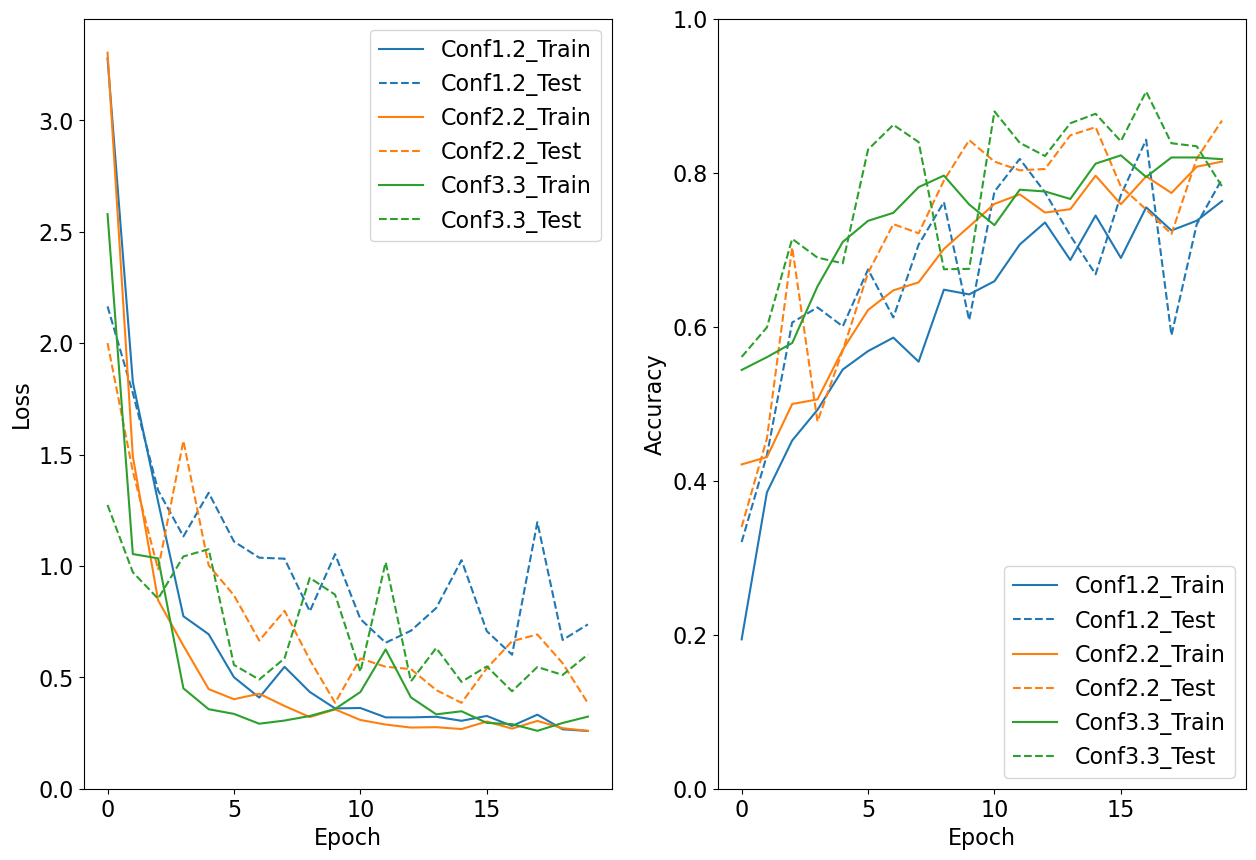

In [17]:
plot_metrics(weighted_history1, weighted_history2, weighted_history3)

In [18]:
# Model.predict gives the predicted output. 
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

 82/500 [===>..........................] - ETA: 0s

2024-01-09 14:52:22.415927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 0s 2ms/step


In [19]:
# Model.predict gives the predicted output. 
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

 76/500 [===>..........................] - ETA: 0s

2024-01-09 14:52:24.360009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 0s 2ms/step


In [20]:
# Model.predict gives the predicted output. 
train_predictions_weighted3 = weighted_model3.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted3 = weighted_model3.predict(x_test, batch_size=BATCH_SIZE)

 87/500 [====>.........................] - ETA: 0s

2024-01-09 14:52:26.024415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


249/249 [==============================] - 1s 3ms/step


loss :  0.7378342747688293
tp :  2774.0
fp :  759.0
tn :  170252.0
fn :  1203.0
accuracy :  0.7918029427528381
precision :  0.7851684093475342
recall :  0.6975107192993164
auc :  0.9824662208557129
prc :  0.8215603828430176



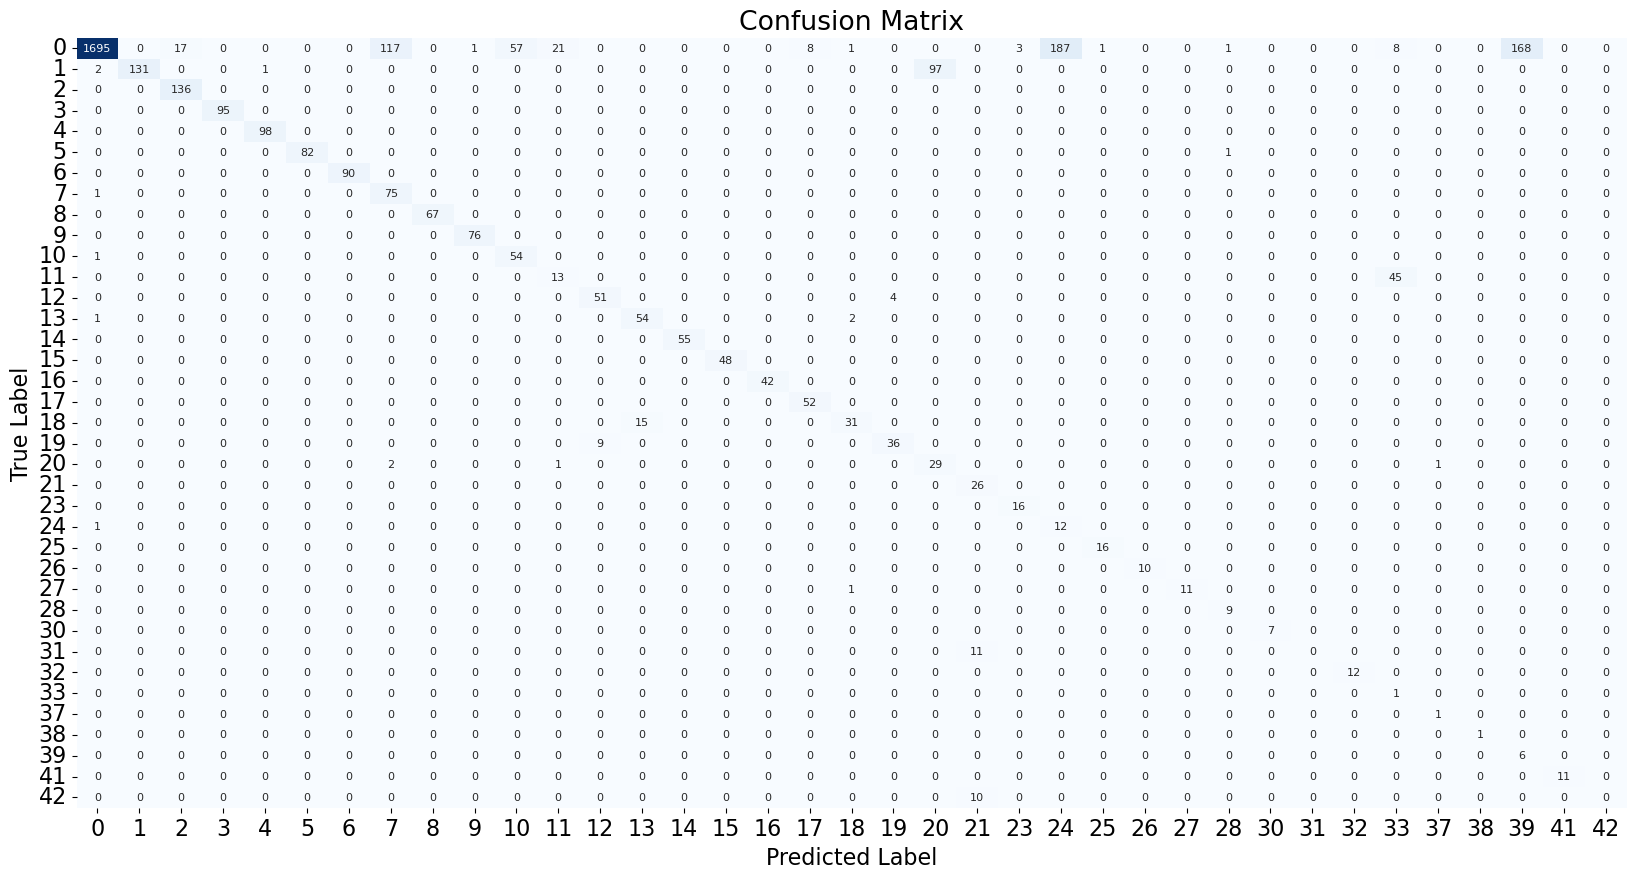

Label 0:
True Positives: 1695
False Positives: 6
False Negatives: 590
True Negatives: 1654
Precision: 0.9964726631393298
Recall: 0.7417943107221007
--------------------
Label 1:
True Positives: 131
False Positives: 0
False Negatives: 100
True Negatives: 3714
Precision: 1.0
Recall: 0.5670995670995671
--------------------
Label 2:
True Positives: 136
False Positives: 17
False Negatives: 0
True Negatives: 3792
Precision: 0.8888888888888888
Recall: 1.0
--------------------
Label 3:
True Positives: 95
False Positives: 0
False Negatives: 0
True Negatives: 3850
Precision: 1.0
Recall: 1.0
--------------------
Label 4:
True Positives: 98
False Positives: 1
False Negatives: 0
True Negatives: 3846
Precision: 0.98989898989899
Recall: 1.0
--------------------
Label 5:
True Positives: 82
False Positives: 0
False Negatives: 1
True Negatives: 3862
Precision: 1.0
Recall: 0.9879518072289156
--------------------
Label 6:
True Positives: 90
False Positives: 0
False Negatives: 0
True Negatives: 3855
Precis

In [21]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model1.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results):
  print(name, ': ', value)
print()


plot_cm_multiclass(y_test, test_predictions_weighted1)

loss :  0.3839681148529053
tp :  3420.0
fp :  469.0
tn :  170542.0
fn :  557.0
accuracy :  0.8677395582199097
precision :  0.8794034719467163
recall :  0.859944760799408
auc :  0.9956137537956238
prc :  0.9361574053764343



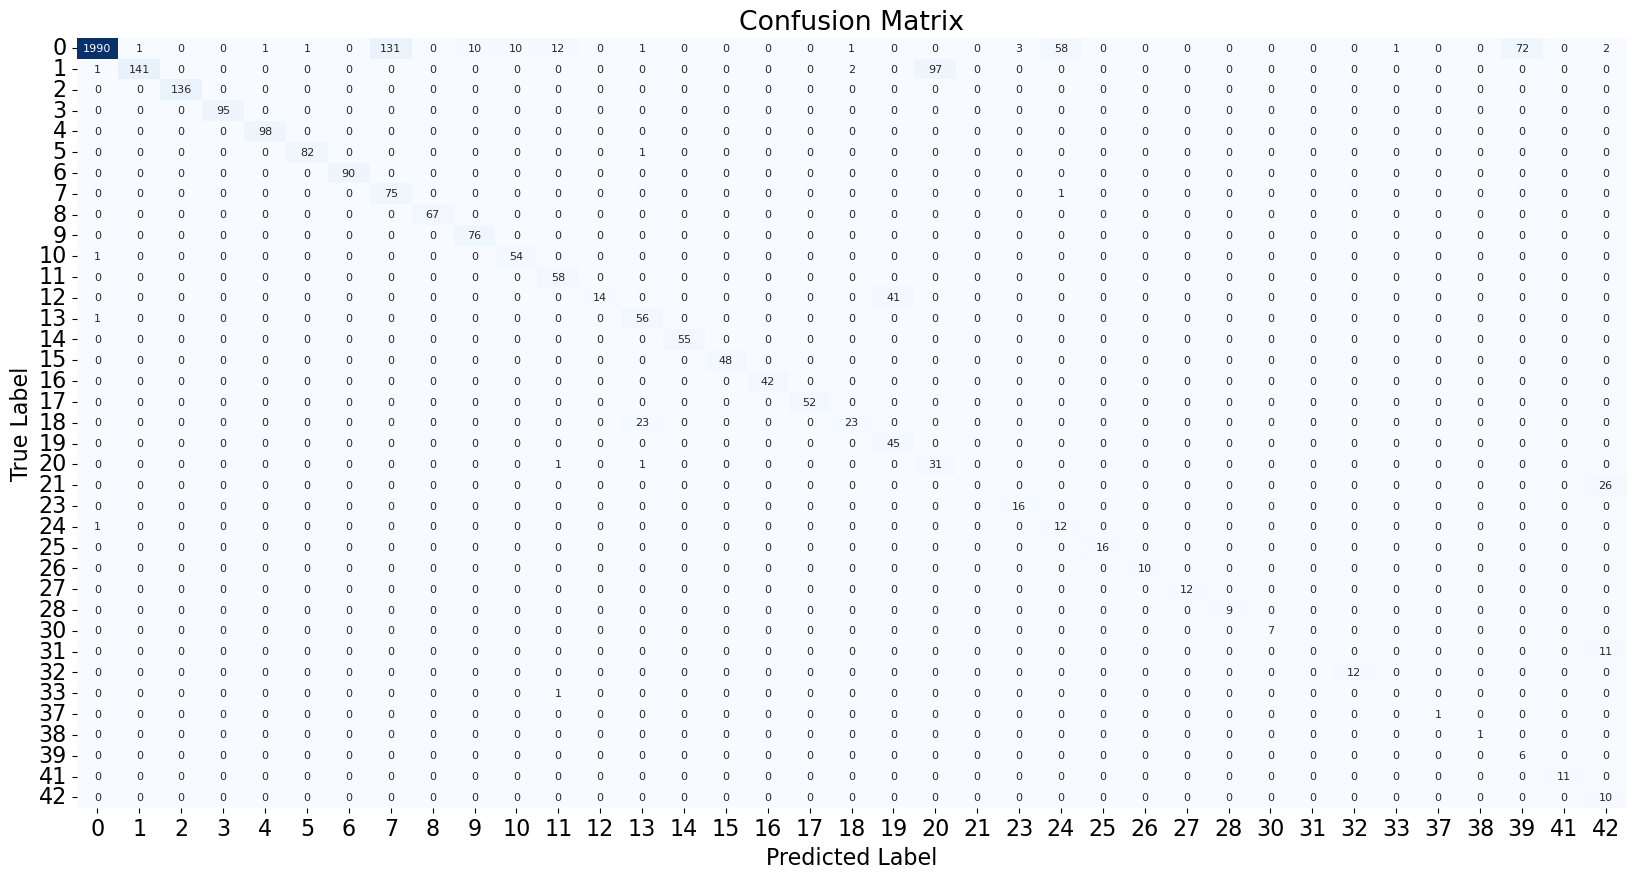

Label 0:
True Positives: 1990
False Positives: 4
False Negatives: 304
True Negatives: 1666
Precision: 0.9979939819458375
Recall: 0.8674803836094158
--------------------
Label 1:
True Positives: 141
False Positives: 1
False Negatives: 100
True Negatives: 3722
Precision: 0.9929577464788732
Recall: 0.5850622406639004
--------------------
Label 2:
True Positives: 136
False Positives: 0
False Negatives: 0
True Negatives: 3828
Precision: 1.0
Recall: 1.0
--------------------
Label 3:
True Positives: 95
False Positives: 0
False Negatives: 0
True Negatives: 3869
Precision: 1.0
Recall: 1.0
--------------------
Label 4:
True Positives: 98
False Positives: 1
False Negatives: 0
True Negatives: 3865
Precision: 0.98989898989899
Recall: 1.0
--------------------
Label 5:
True Positives: 82
False Positives: 1
False Negatives: 1
True Negatives: 3880
Precision: 0.9879518072289156
Recall: 0.9879518072289156
--------------------
Label 6:
True Positives: 90
False Positives: 0
False Negatives: 0
True Negative

In [22]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model2.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm_multiclass(y_test, test_predictions_weighted2)

loss :  0.6028379797935486
tp :  3065.0
fp :  837.0
tn :  170174.0
fn :  912.0
accuracy :  0.7822479605674744
precision :  0.7854946255683899
recall :  0.7706815004348755
auc :  0.9929476976394653
prc :  0.8983826637268066



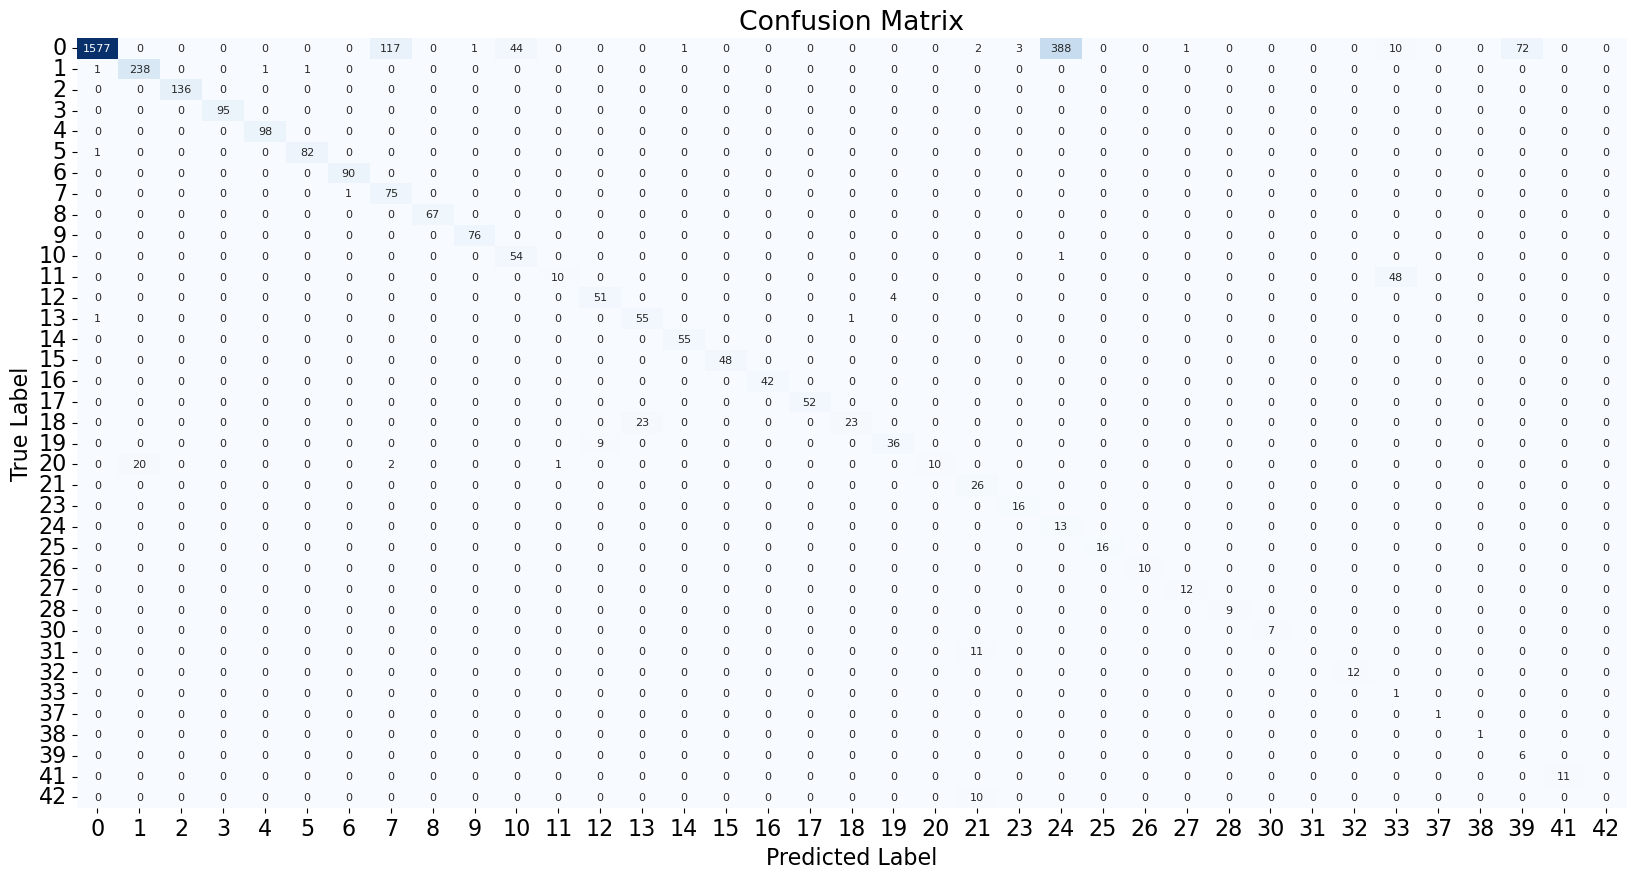

Label 0:
True Positives: 1577
False Positives: 3
False Negatives: 639
True Negatives: 1667
Precision: 0.9981012658227848
Recall: 0.7116425992779783
--------------------
Label 1:
True Positives: 238
False Positives: 20
False Negatives: 3
True Negatives: 3625
Precision: 0.9224806201550387
Recall: 0.9875518672199171
--------------------
Label 2:
True Positives: 136
False Positives: 0
False Negatives: 0
True Negatives: 3750
Precision: 1.0
Recall: 1.0
--------------------
Label 3:
True Positives: 95
False Positives: 0
False Negatives: 0
True Negatives: 3791
Precision: 1.0
Recall: 1.0
--------------------
Label 4:
True Positives: 98
False Positives: 1
False Negatives: 0
True Negatives: 3787
Precision: 0.98989898989899
Recall: 1.0
--------------------
Label 5:
True Positives: 82
False Positives: 1
False Negatives: 1
True Negatives: 3802
Precision: 0.9879518072289156
Recall: 0.9879518072289156
--------------------
Label 6:
True Positives: 90
False Positives: 1
False Negatives: 0
True Negatives

In [23]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model3.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model3.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm_multiclass(y_test, test_predictions_weighted3)

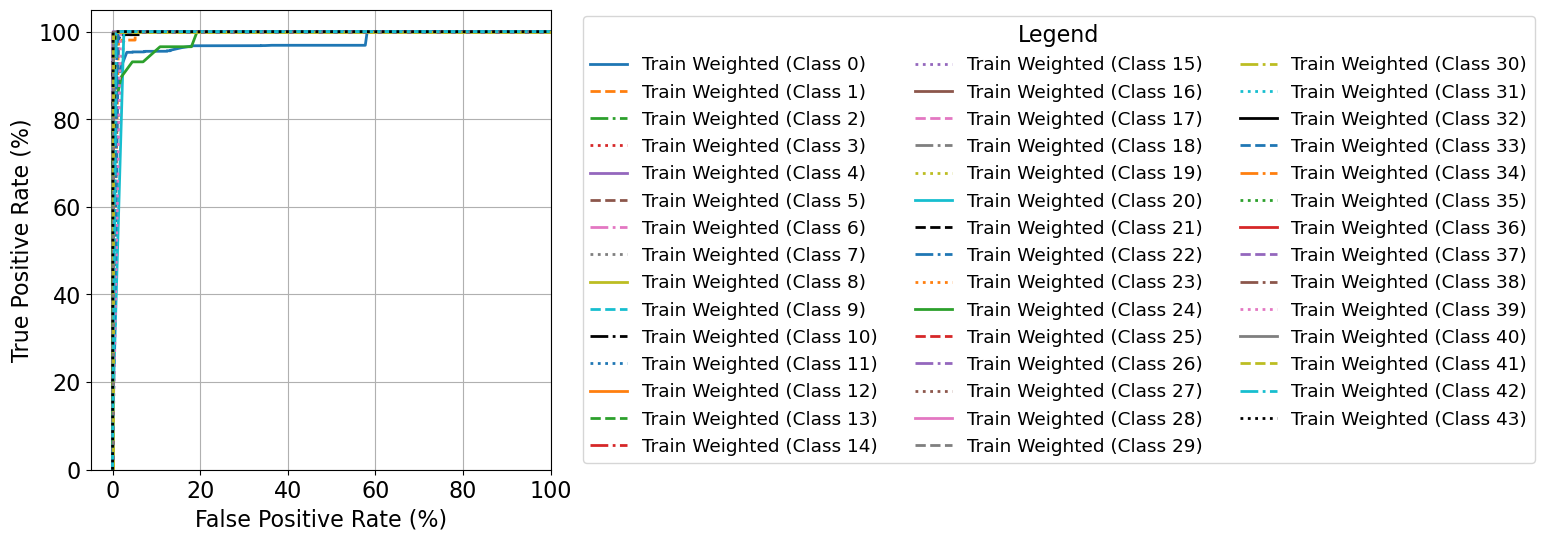

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

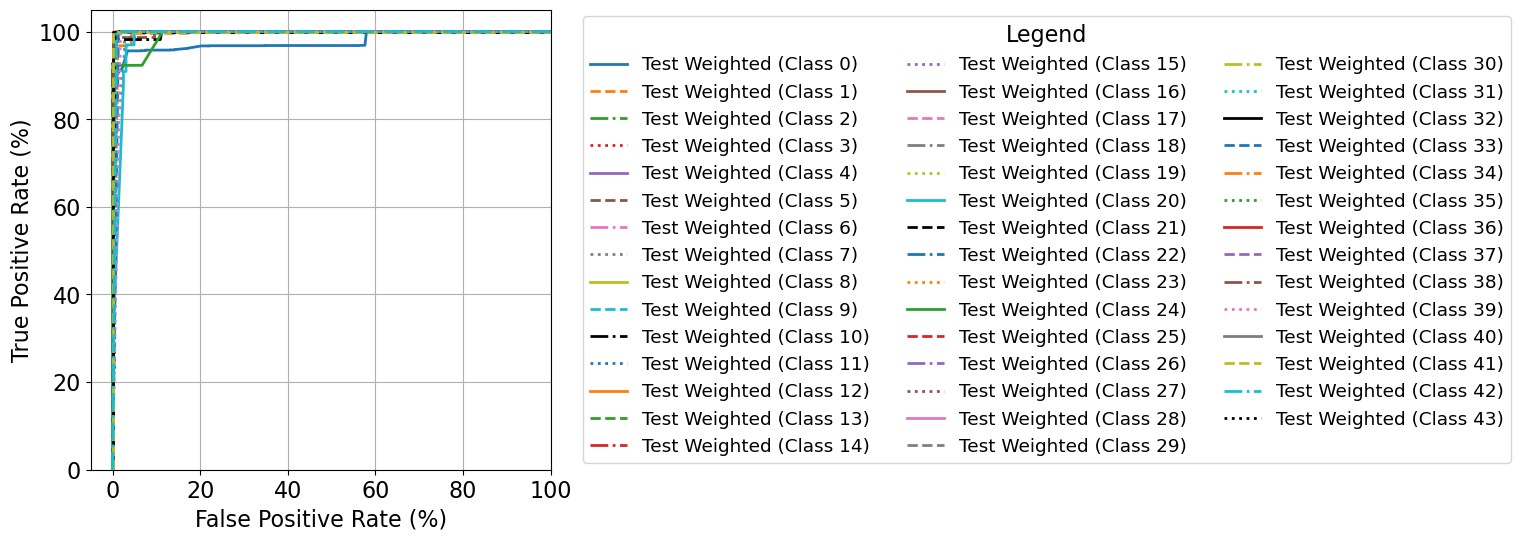

In [24]:
plot_roc("Train Weighted", y_train, train_predictions_weighted1)
plot_roc("Test Weighted", y_test, test_predictions_weighted1)

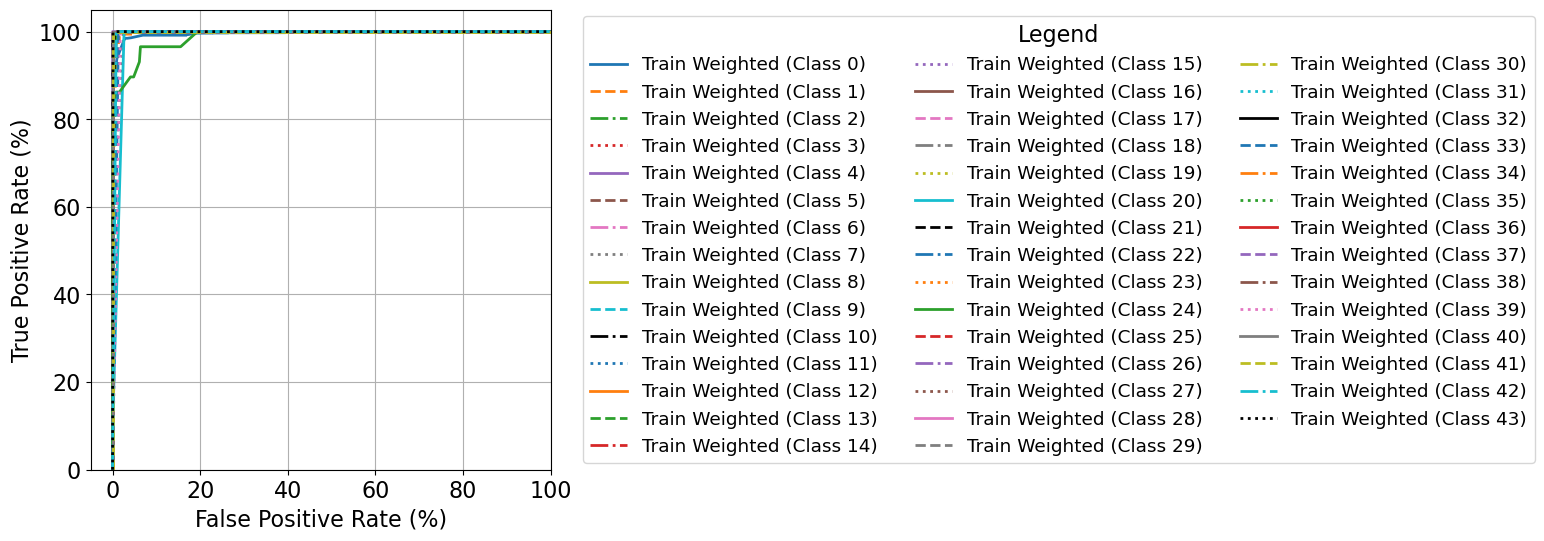

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

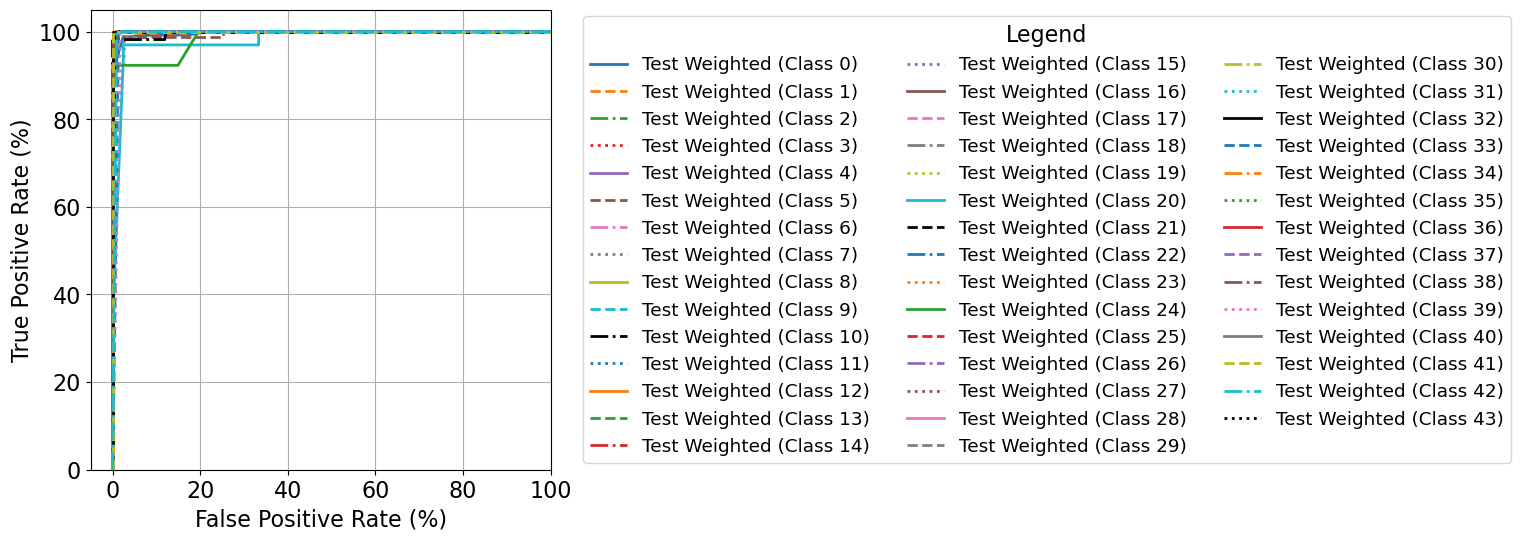

In [25]:
plot_roc("Train Weighted", y_train, train_predictions_weighted2)
plot_roc("Test Weighted", y_test, test_predictions_weighted2)

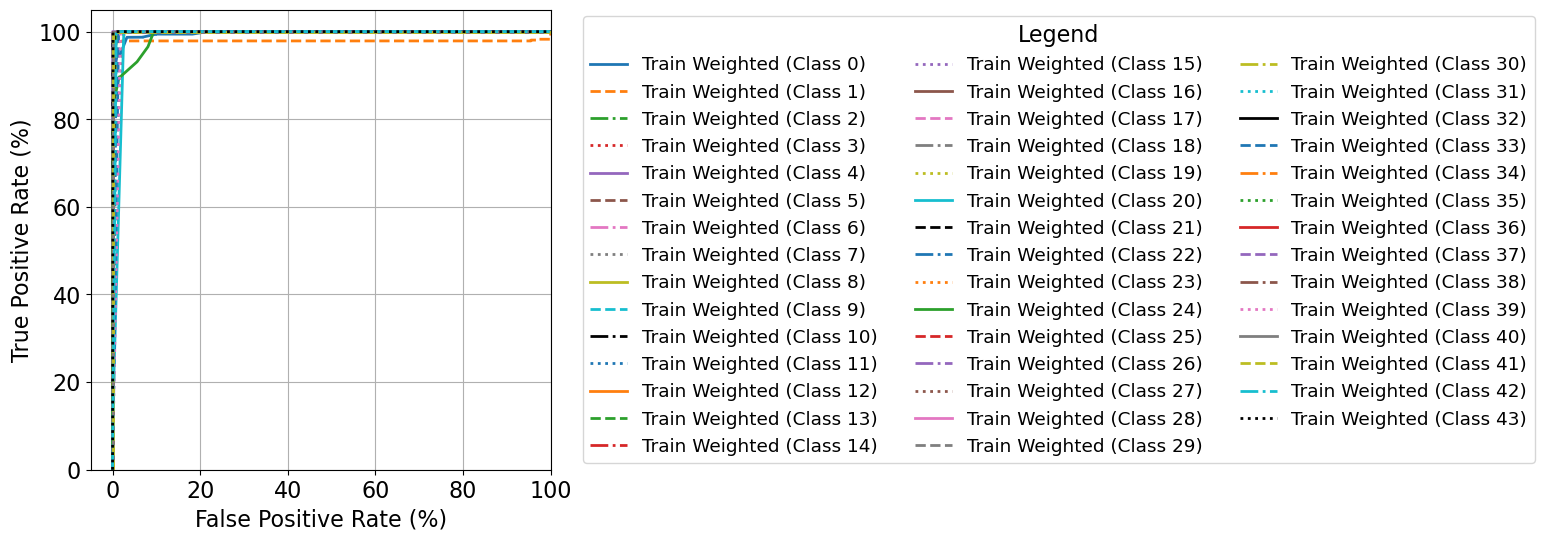

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positiv

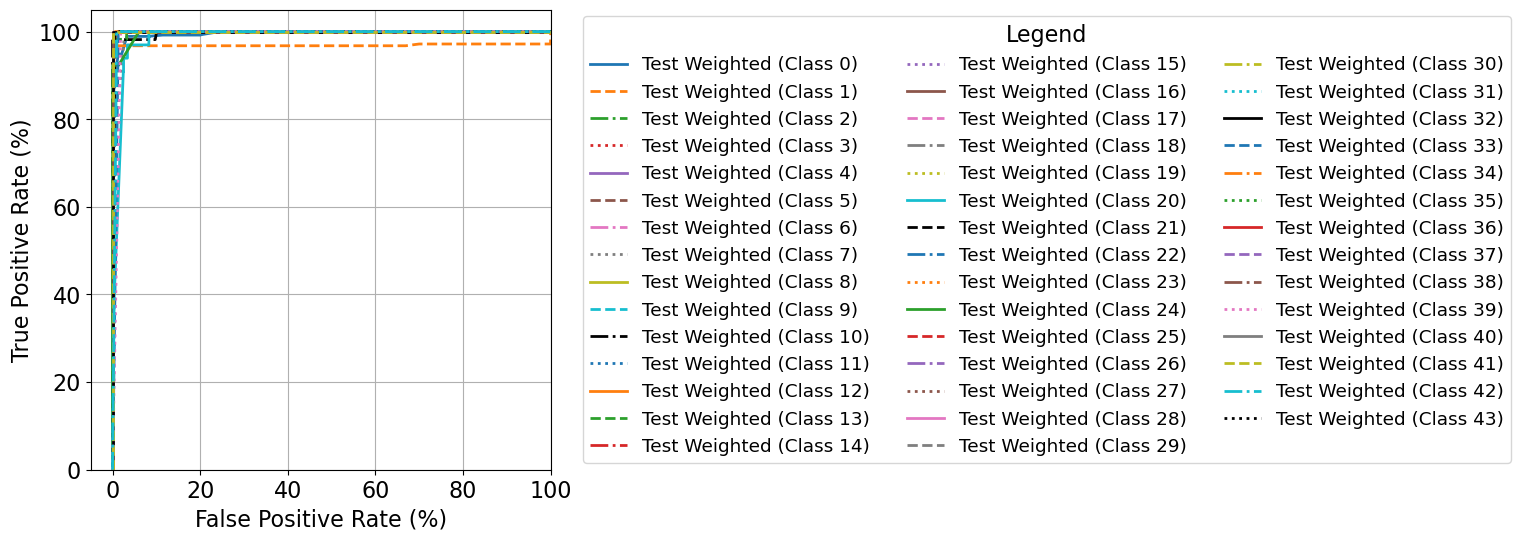

In [26]:
plot_roc("Train Weighted", y_train, train_predictions_weighted3)
plot_roc("Test Weighted", y_test, test_predictions_weighted3)

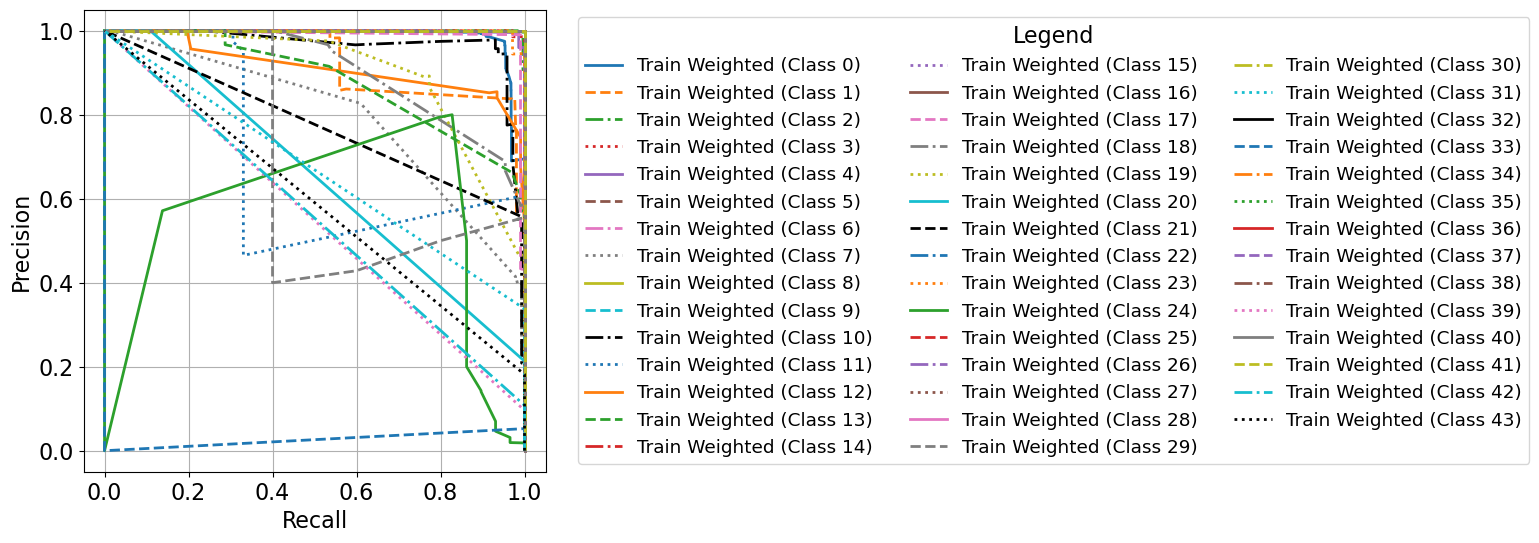

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

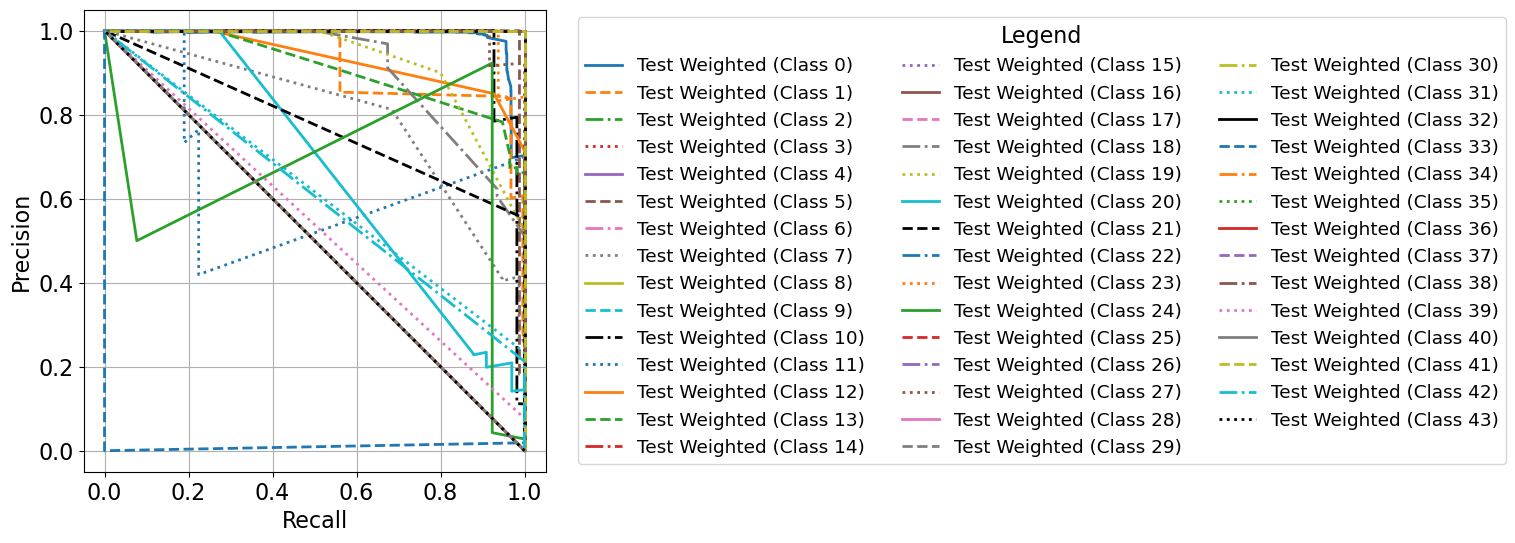

In [27]:
plot_prc("Train Weighted", y_train, train_predictions_weighted1)
plot_prc("Test Weighted", y_test, test_predictions_weighted1)

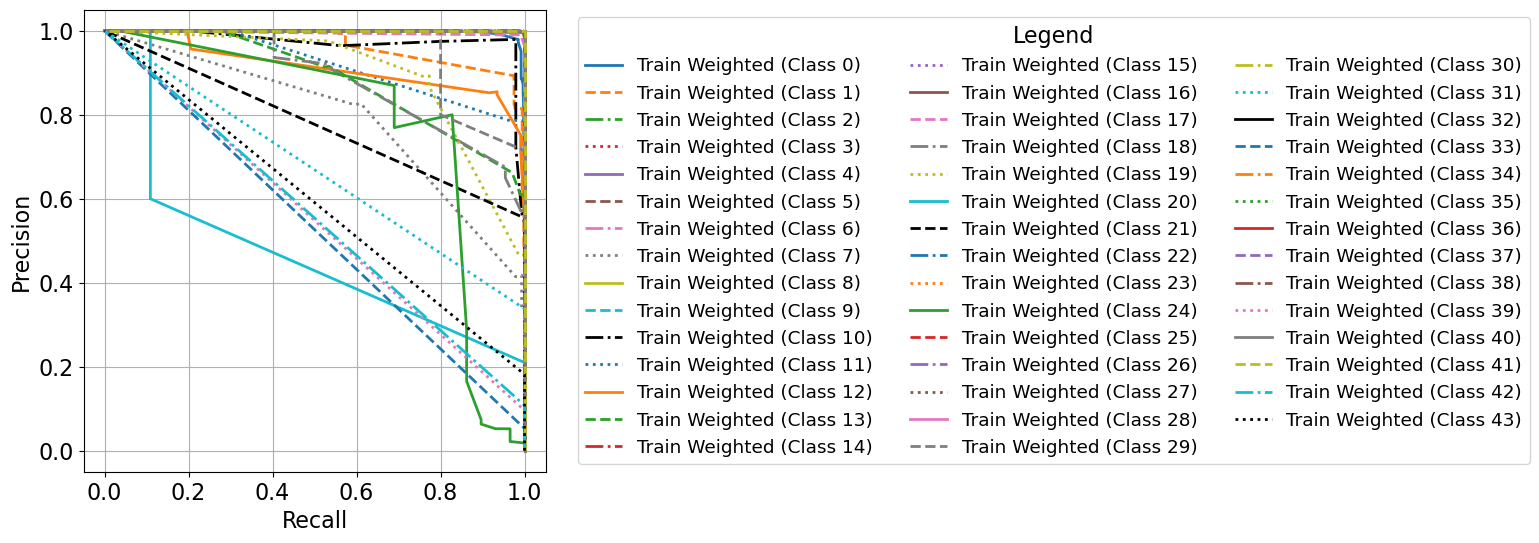

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

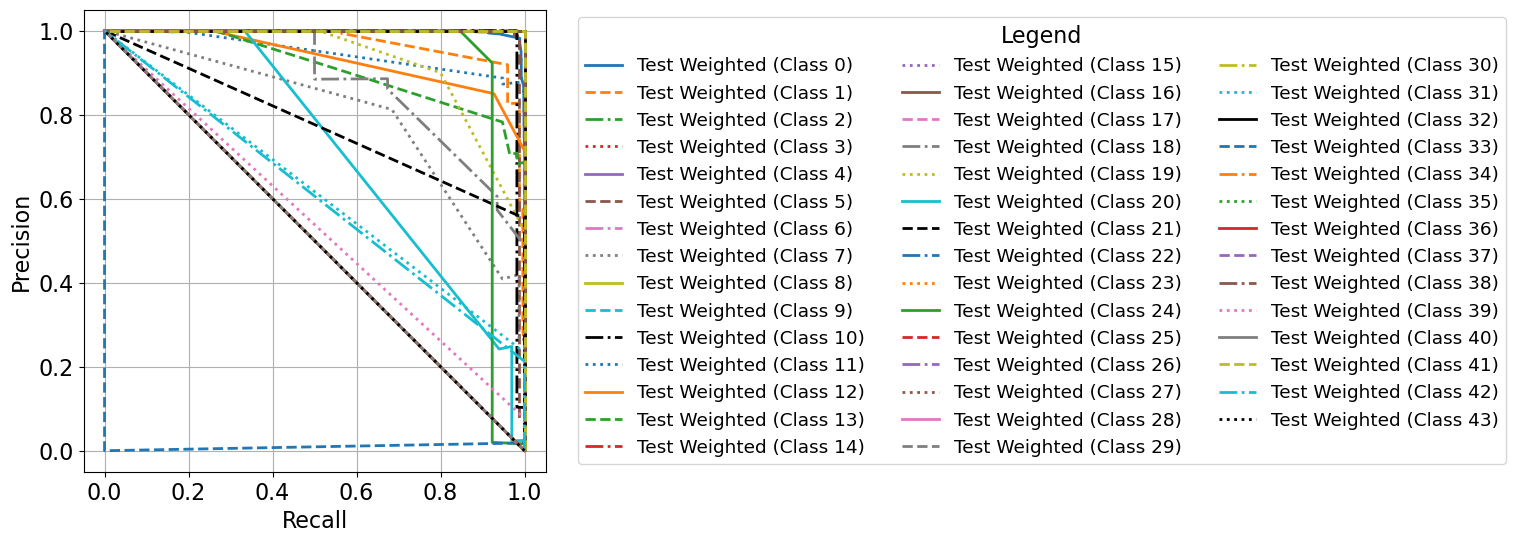

In [28]:
plot_prc("Train Weighted", y_train, train_predictions_weighted2)
plot_prc("Test Weighted", y_test, test_predictions_weighted2)

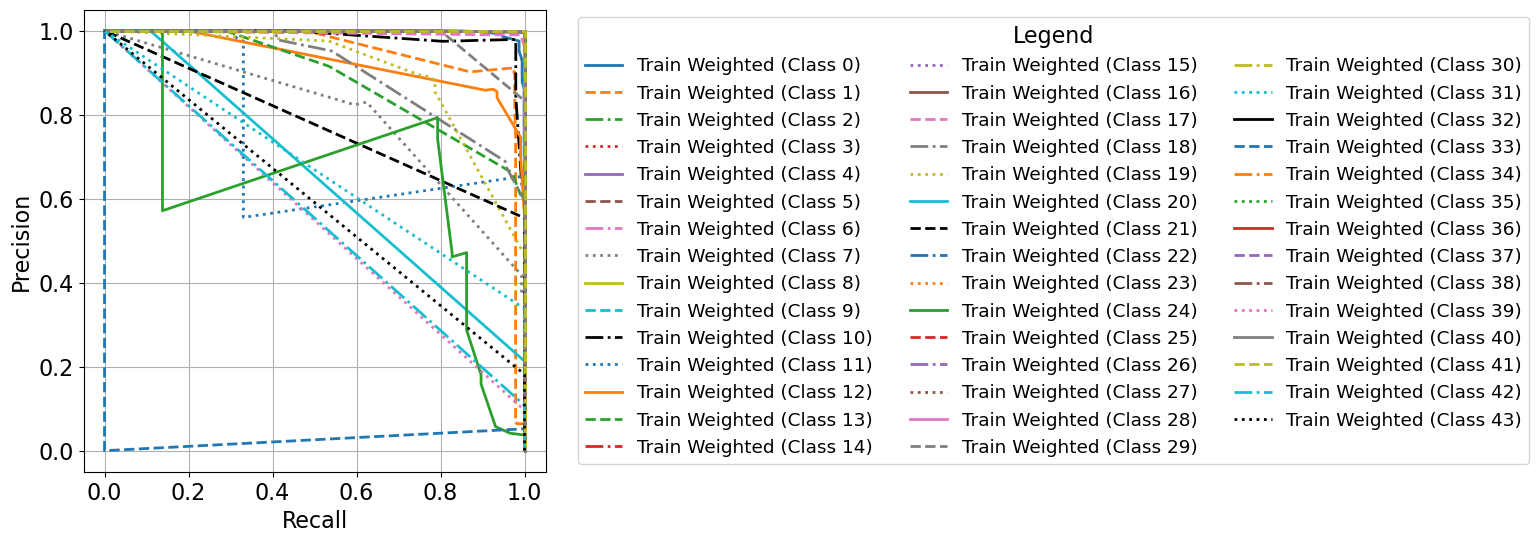

/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/amanda/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one fo

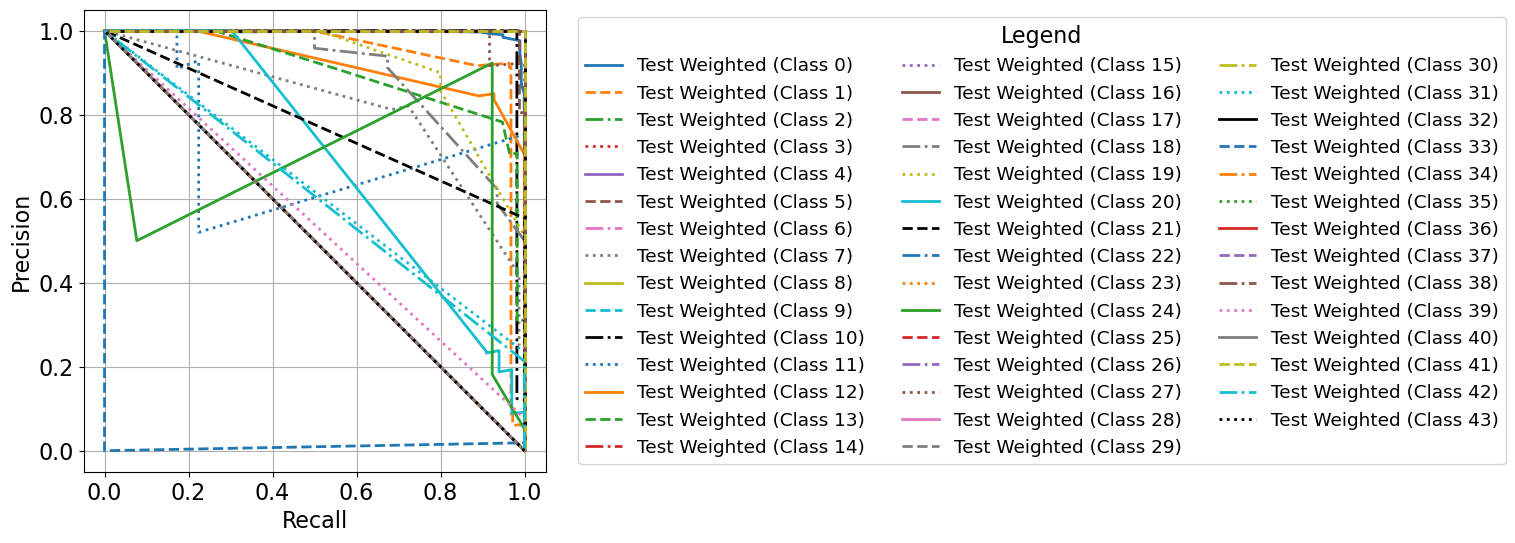

In [29]:
plot_prc("Train Weighted", y_train, train_predictions_weighted3)
plot_prc("Test Weighted", y_test, test_predictions_weighted3)